In [20]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from joblib import Parallel, delayed
from scipy.signal import savgol_filter as sgf
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn import metrics


In [21]:
Synth = pd.read_csv('CsPbBr_synthesis.csv', index_col = 0)

In [22]:
def conc_factor(di=1,mw=1,density=1,conc=0):
    result = 0
    if conc != 0:
        return conc/500/di
    else:
        volume = 1 #in ul
        mass = (volume/1000000)/di*density #g
        amount = mass/mw #mol
        result = amount*1000*1000000/500
        return result #converting into mM
    
        
#Dilution ratio:
#Cs Pb 200,OLA 100, Br OA 80
SynData = pd.DataFrame()
#Cesium Concentration in mM
SynData['Cs'] = Synth['Cs']*conc_factor(di=200,conc=1000)
#Lead Concentration in mM
SynData['Pb'] = Synth['Pb']*conc_factor(di=200,conc=667)
#Oleylamine Concentration in mM
SynData['OLA'] = Synth['OLA']*conc_factor(di=100,mw=267.5,density=813)
#Oleic Acid Concentration in mM
SynData['OA'] = (Synth['OA']+Synth['Cs']+Synth['Pb'])*conc_factor(di=80,mw=282.5,density=895)
#Benzoyl Bromide Concentration in mM
SynData['Br'] = Synth['Br']*conc_factor(di=80,mw=185,density=1570)
#Temperature in Celcius
SynData['Temp'] = Synth['Temp'] + 273
#Normalized Concentration of Products
SynData['PbBr3-'] = Synth['PbBr3-']
SynData['Cs4PbBr6'] = Synth['Cs4PbBr6']
SynData['CsPb2Br5'] = Synth['CsPb2Br5']
SynData['PbBr2'] = Synth['PbBr2']
SynData['1ML'] = Synth['1 ML']
SynData['2ML'] = Synth['2 ML']
SynData['3ML'] = Synth['3 ML']
SynData['4ML'] = Synth['4 ML']
SynData['CsPbBr3'] = Synth['CsPbBr3']

In [23]:
#Defining a function to create copy of a DataFrame
def dfcopy(DataFrame):
    result = pd.DataFrame()
    for i in DataFrame.columns:
        result[i] = DataFrame[i]
    return result 

#Defining a function for avg = 1:
def dfscale(DataFrame):
    result = pd.DataFrame()
    for i in DataFrame.columns:
        avg = DataFrame[i].mean()
        result[i] = DataFrame[i]/avg
    return result

In [24]:
#Defining a function to perform feature engineering
def addfeatures(train_a1):
    train_a1eus = dfcopy(train_a1)
    train_a1eus['OA/OLA ^2'] = (train_a1['OA']/train_a1['OLA'])**2
    train_a1eus['Pb/OLA ^2'] = (train_a1['Pb']/train_a1['OLA'])**2
    train_a1eus['Pb/OA ^2'] = (train_a1['Pb']/train_a1['OA'])**2
    train_a1eus['Cs/OLA ^0.5'] = (train_a1['Cs']/train_a1['OLA'])**(1/2)
    train_a1eus['Pb/L ^0.5'] = (train_a1['Pb']/(train_a1['OA']+train_a1['OLA']))**(1/2)
    train_a1eus['Cs ^2'] = train_a1['Cs']**2
    train_a1eus['OLA ^2'] = train_a1['OLA']**2
    train_a1eus['Br ^2'] = train_a1['Br']**2
    train_a1eus['Temp ^2'] = train_a1['Temp']**2
    return train_a1eus

In [25]:
#Def: Obtaining R^2 for each species
from sklearn.metrics import r2_score

def r2model(model,feature,label):
    prediction = model.predict(feature)
    prediction_df = pd.DataFrame(prediction,index = label.index,columns = label.columns)
    results = []
    for i in label.columns:
        results.append(r2_score(label[i],prediction_df[i]))
    return results

In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(SynData, test_size=0.2,random_state=42)

labels = ['PbBr3-','Cs4PbBr6','CsPb2Br5','PbBr2','CsPbBr3','1ML','2ML','3ML','4ML']
attributes = ['Cs','Pb','OLA','OA','Br','Temp']
test_l = test_set[labels]
test_a = test_set[attributes]
train_l = train_set[labels]
train_a = train_set[attributes]

train_as = dfscale(train_a)
train_aeus = addfeatures(train_a)
train_ae = dfscale(train_aeus)
test_as = dfscale(test_a)
test_aeus = addfeatures(test_a)
test_ae = dfscale(test_aeus)

**Prediction of all but CsPbBr3**

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf_1=RandomForestRegressor(random_state=42,max_depth=58,max_features=15,min_samples_split=2,min_samples_leaf=2)
rf_1.fit(train_ae,train_l)

RandomForestRegressor(max_depth=58, max_features=15, min_samples_leaf=2,
                      random_state=42)

In [36]:
#Test set prediction
data1 = rf_1.predict(test_ae)
pred = {}
for i in labels:
    pos = labels.index(i)
    pred[i] = data1[:,pos]

In [44]:
#Training set prediction
data2 = rf_1.predict(train_ae)
trains = {}
for i in labels:
    pos = labels.index(i)
    trains[i] = data2[:,pos]

**Plotting Scatter Plots**

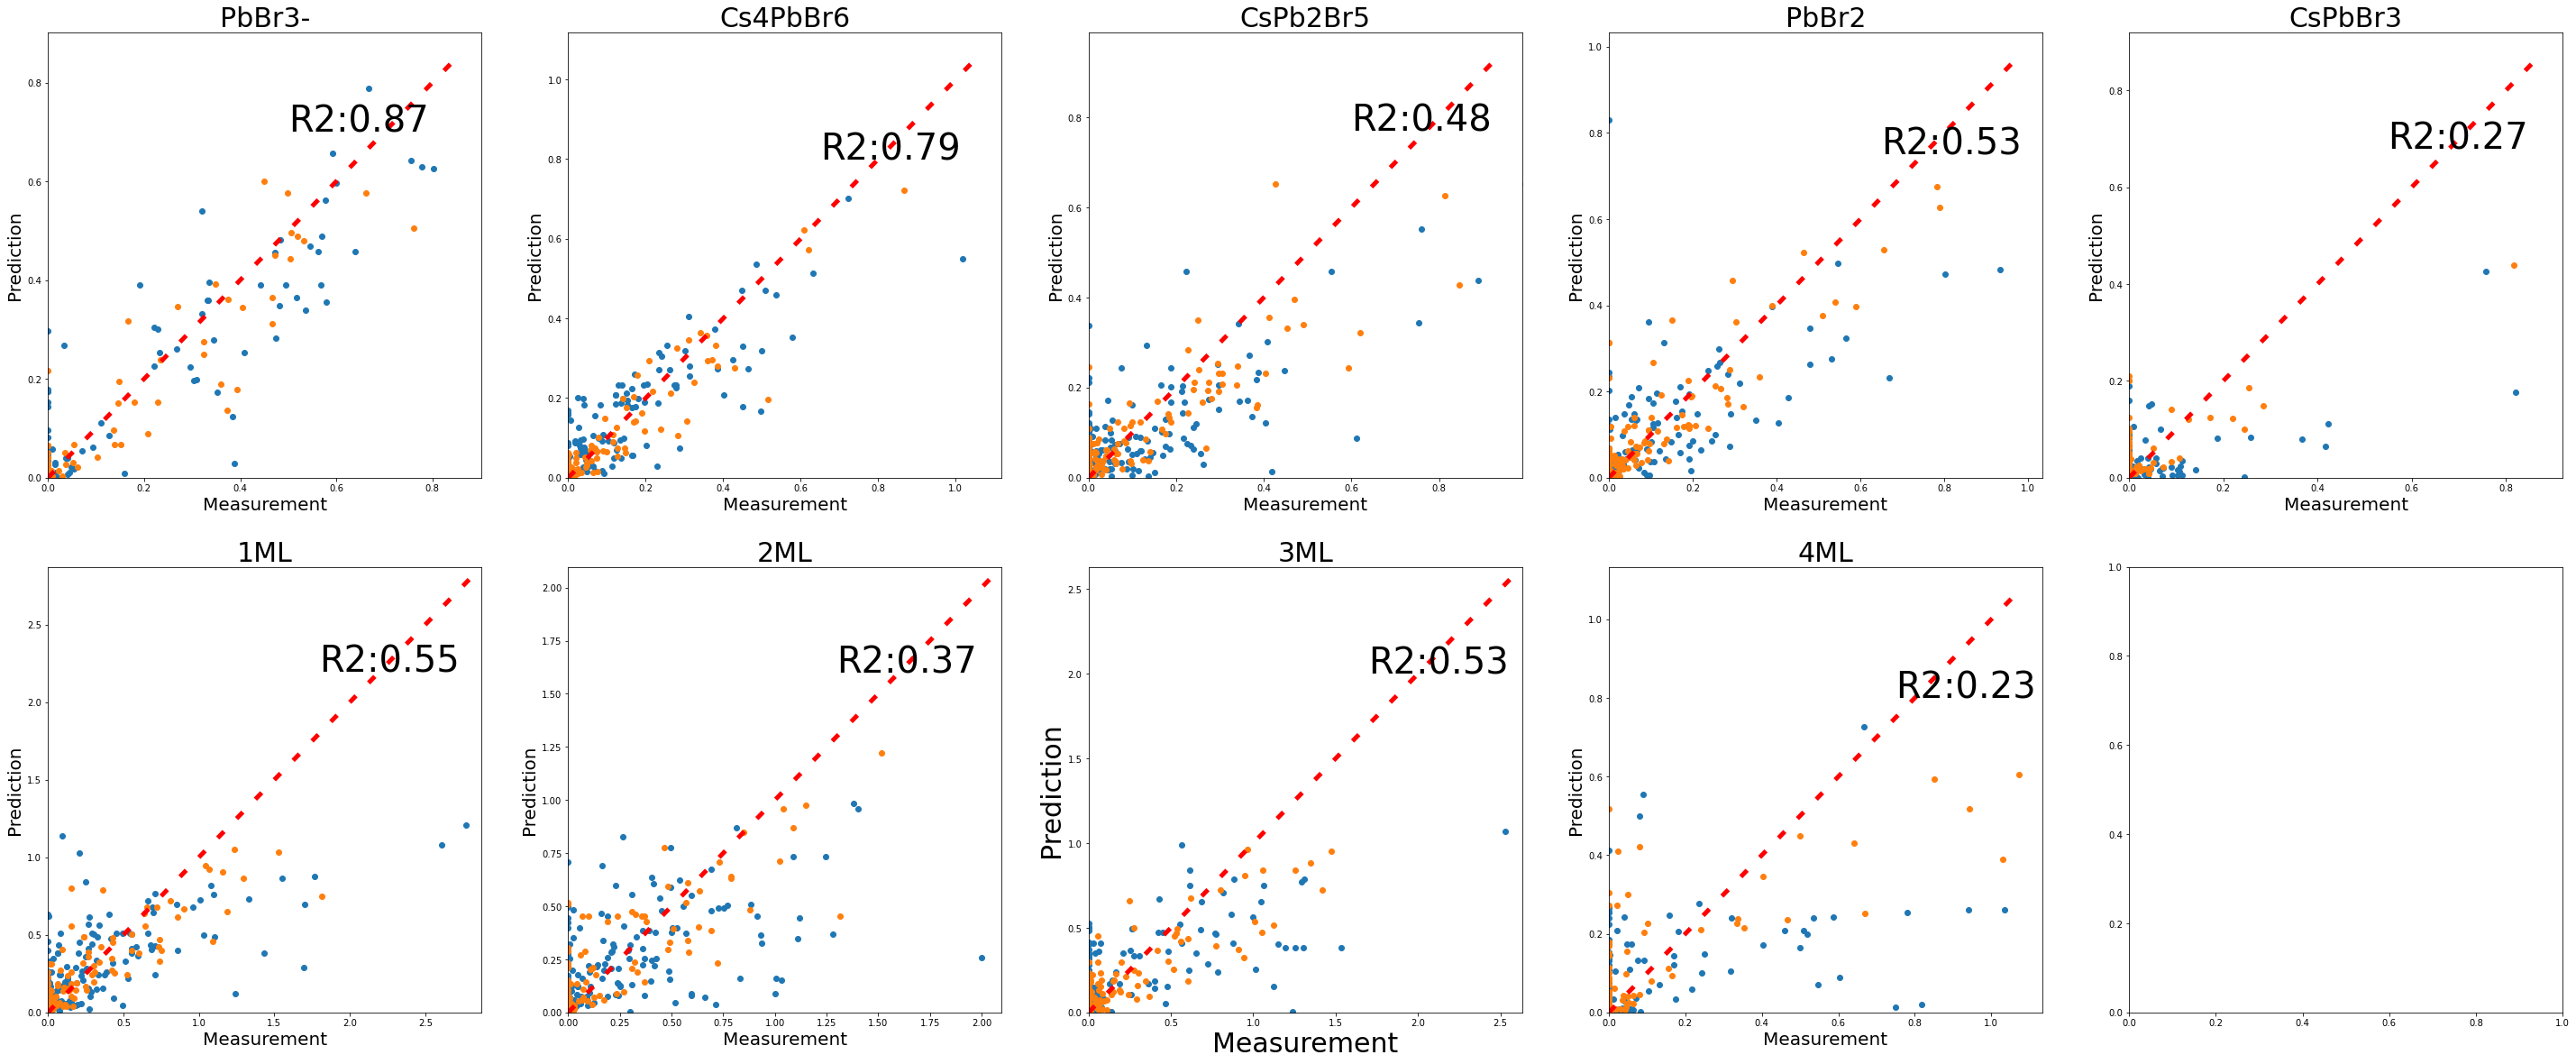

In [67]:
fig, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2, 5, figsize=(50,20))

#['PbBr3-','Cs4PbBr6','CsPb2Br5','PbBr2','CsPbBr3','1ML','2ML','3ML','4ML']
ax1.scatter(test_l['PbBr3-'],pred['PbBr3-'])
ax1.scatter(train_l['PbBr3-'][:200],trains['PbBr3-'][:200])
#set limits to same
lim = max(max(test_l['PbBr3-']),max(pred['PbBr3-']))
ax1.set_xlim(0,lim+0.1)
ax1.set_ylim(0,lim+0.1)
ax1.set_ylabel('Prediction',size = 20)
ax1.set_xlabel('Measurement',size = 20)
ax1.set_title('PbBr3-',size=30)
ax1.text(0.5,0.7,'R2:0.87',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax1.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax2.scatter(test_l['Cs4PbBr6'],pred['Cs4PbBr6'])
ax2.scatter(train_l['Cs4PbBr6'][:200],trains['Cs4PbBr6'][:200])
#set limits to same
lim = max(max(test_l['Cs4PbBr6']),max(pred['Cs4PbBr6']))
ax2.set_xlim(0,lim+0.1)
ax2.set_ylim(0,lim+0.1)
ax2.set_ylabel('Prediction',size = 20)
ax2.set_xlabel('Measurement',size = 20)
ax2.set_title('Cs4PbBr6',size=30)
ax2.text(0.65,0.8,'R2:0.79',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax2.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax3.scatter(test_l['CsPb2Br5'],pred['CsPb2Br5'])
ax3.scatter(train_l['CsPb2Br5'][:200],trains['CsPb2Br5'][:200])
#set limits to same
lim = max(max(test_l['CsPb2Br5']),max(pred['CsPb2Br5']))
ax3.set_xlim(0,lim+0.1)
ax3.set_ylim(0,lim+0.1)
ax3.set_ylabel('Prediction',size = 20)
ax3.set_xlabel('Measurement',size = 20)
ax3.set_title('CsPb2Br5',size=30)
ax3.text(0.6,0.77,'R2:0.48',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax3.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax4.scatter(test_l['PbBr2'],pred['PbBr2'])
ax4.scatter(train_l['PbBr2'][:200],trains['PbBr2'][:200])
#set limits to same
lim = max(max(test_l['PbBr2']),max(pred['PbBr2']))
ax4.set_xlim(0,lim+0.1)
ax4.set_ylim(0,lim+0.1)
ax4.set_ylabel('Prediction',size = 20)
ax4.set_xlabel('Measurement',size = 20)
ax4.set_title('PbBr2',size=30)
ax4.text(0.65,0.75,'R2:0.53',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax4.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax5.scatter(test_l['CsPbBr3'],pred['CsPbBr3'])
ax5.scatter(train_l['CsPbBr3'][:200],trains['CsPbBr3'][:200])
#set limits to same
lim = max(max(test_l['CsPbBr3']),max(pred['CsPbBr3']))
ax5.set_xlim(0,lim+0.1)
ax5.set_ylim(0,lim+0.1)
ax5.set_ylabel('Prediction',size = 20)
ax5.set_xlabel('Measurement',size = 20)
ax5.set_title('CsPbBr3',size=30)
ax5.text(0.55,0.68,'R2:0.27',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax5.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax6.scatter(test_l['1ML'],pred['1ML'])
ax6.scatter(train_l['1ML'][:200],trains['1ML'][:200])
#set limits to same
lim = max(max(test_l['1ML']),max(pred['1ML']))
ax6.set_xlim(0,lim+0.1)
ax6.set_ylim(0,lim+0.1)
ax6.set_ylabel('Prediction',size = 20)
ax6.set_xlabel('Measurement',size = 20)
ax6.set_title('1ML',size=30)
ax6.text(1.8,2.2,'R2:0.55',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax6.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax7.scatter(test_l['2ML'],pred['2ML'])
ax7.scatter(train_l['2ML'][:200],trains['2ML'][:200])
#set limits to same
lim = max(max(test_l['2ML']),max(pred['2ML']))
ax7.set_xlim(0,lim+0.1)
ax7.set_ylim(0,lim+0.1)
ax7.set_ylabel('Prediction',size = 20)
ax7.set_xlabel('Measurement',size = 20)
ax7.set_title('2ML',size=30)
ax7.text(1.3,1.6,'R2:0.37',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax7.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax8.scatter(test_l['3ML'],pred['3ML'])
ax8.scatter(train_l['3ML'][:200],trains['3ML'][:200])
#set limits to same
lim = max(max(test_l['3ML']),max(pred['3ML']))
ax8.set_xlim(0,lim+0.1)
ax8.set_ylim(0,lim+0.1)
ax8.set_ylabel('Prediction',size = 30)
ax8.set_xlabel('Measurement',size = 30)
ax8.set_title('3ML',size=30)
ax8.text(1.7,2,'R2:0.53',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax8.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

ax9.scatter(test_l['4ML'],pred['4ML'])
ax9.scatter(train_l['4ML'][:200],trains['4ML'][:200])
#set limits to same
lim = max(max(test_l['4ML']),max(pred['4ML']))
ax9.set_xlim(0,lim+0.1)
ax9.set_ylim(0,lim+0.1)
ax9.set_ylabel('Prediction',size = 20)
ax9.set_xlabel('Measurement',size = 20)
ax9.set_title('4ML',size=30)
ax9.text(0.75,0.8,'R2:0.23',size=40)
#reference line
dashes = [2,4]
xs = np.arange(0.0, lim+0.05, 0.01)
ld, = ax9.plot(xs,xs,'--',color='red',linewidth=5)
ld.set_dashes(dashes)

In [66]:
r2_score(train_l['CsPbBr3'][:200],trains['CsPbBr3'][:200])

0.4607600532331003